In [5]:
import json
import pickle

In [6]:
questions = []
contexts = []
examples = []
labels = []
id2idx = {}
files = ["dataset/train-v2.0.json",  "dataset/dev-v2.0.json"]
for file in files:
    with open(file, 'r') as handle:
        jdata = json.load(handle)
        data = jdata['data']
    for i in range(len(data)):
        section = data[i]['paragraphs']
        for sec in section:
            context = sec['context']
            contexts.append(context)
            qas = sec['qas']
            for j in range(len(qas)):
                question = qas[j]['question']
                is_imp = qas[j]['is_impossible']
                qid = qas[j]['id']
                questions.append(question)
                labels.append(is_imp)
                examples.append((len(contexts)-1, len(questions)-1))
                id2idx[qid] = len(questions)-1

In [7]:
ftmp = "qparts/copy_parts2/parsed_qs_labels%s.pkl"
parses = {}
for i in range(24):
    fname = ftmp % str(i)
    with open(fname, "rb") as f:
        data = pickle.load(f)
        parses.update(data)

In [26]:
negation_terms = [' not ', "don't", "couldn't", "wouldn't", "wasn't", "isn't", "doesn't", "aren't", "didn't", "n't"]
negation_terms = [' not ',  "n't"]

In [27]:
from collections import Counter

In [28]:
neg_counter = Counter()
for i, q in enumerate(questions):
    for t in negation_terms:
        if t in q:
            neg_counter['total'] += 1
            neg_counter[t] += 1
            if labels[i] == False:
                neg_counter['ans'] += 1
            else:
                neg_counter['unans'] += 1

In [29]:
print(len(questions))
print("Total negs:", neg_counter['total'])
print("Total negs in Ans", neg_counter['ans'])
print("Total negs in Unans", neg_counter['unans'])

142192
Total negs: 5925
Total negs in Ans 1509
Total negs in Unans 4416


In [30]:
neg_counter

Counter({'total': 5925,
         ' not ': 4002,
         'ans': 1509,
         "n't": 1923,
         'unans': 4416})

In [81]:
ans_neg = []
for i, q in enumerate(questions):
    found = False
    for t in negation_terms:
        if t in q and labels[i] == False:
            ans_neg.append(q)
                

In [82]:
import random

In [83]:
for q in random.sample(ans_neg, 25):
    print(q)

In The Sing-Off, where did the groups not from the United States come from?
Was there a time this was not the case? 
Who questioned the claim that South Korean did not provoke the KPA?
Peter J. Wallison's conclusions regarding the financial crisis are not in agreement with this economist's views?
During what year was Barcelona not allowed to use  their transfer windows?
A contract can be given to someone who is not the best what?
What is not an established science?
Who was one person who did not fully believe the struggle of conscience?
The Air Ministry and which other group decided to not make night defense a top priority?
Are adolescents or children better able to understand that people do not have complete control over their thoughts?
Richard Lewontin, upon looking at the FST ratios, concluded race wasn't an appropriate or useful way to describe what?
Who declared that France would not yield "an inch of its territory?"
How are the votes weighted to ensure that smaller states aren't 

In [85]:
counter = Counter()
for i, q in enumerate(questions):
    context = contexts[examples[i][0]]
    found_in_q = False
    found_in_c = False
    for t in negation_terms:
        if t in q:
            found_in_q = True
    for t in negation_terms:
        if t in context:
            found_in_c = True
    if found_in_q:
        if labels[i] == False:
            counter[('ANS', found_in_c)] += 1
        else:
            counter[('UNANS', found_in_c)] += 1

In [86]:
counter

Counter({('ANS', True): 1047,
         ('ANS', False): 460,
         ('UNANS', False): 2901,
         ('UNANS', True): 1506})

In [87]:
#P(UNANS | q=Neg, c=NF)
2901 / (2901 + 460)

0.8631359714370723

In [92]:
print("% coverage", 2901 / 49443 * 100)

% coverage 5.867362417329046


In [89]:
np.sum([1 for l in labels if l == True])

49443

In [419]:
#counter = Counter()
for i, q in enumerate(questions):
    context = contexts[examples[i][0]]
    found_in_q = False
    found_in_c = False
    for t in negation_terms:
        if t in q:
            found_in_q = True
    for t in negation_terms:
        if t in context:
            found_in_c = True
    if found_in_q:
        if labels[i] == False:
            pass
        else:
            if not found_in_c and i > 2467:
                print(i)
                print(q)
                print(context)
                assert False

2575
Who was not frustrated with the Spectre project?
In November 2014, Sony Pictures Entertainment was targeted by hackers who released details of confidential e-mails between Sony executives regarding several high-profile film projects. Included within these were several memos relating to the production of Spectre, claiming that the film was over budget, detailing early drafts of the script written by John Logan, and expressing Sony's frustration with the project. Eon Productions later issued a statement confirming the leak of what they called "an early version of the screenplay".


AssertionError: 

In [31]:
# copies

In [174]:
from pytorch_pretrained_bert.tokenization import BertTokenizer
import spacy

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
nlp = spacy.load("en_core_web_sm")


INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/daniter/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [39]:
strip_stop = ["a", "an", "and", "as", "or", "the", "that", "which", "when", "whose", "is", "was", "what", "to", "of"]

def simple_filter(term):
    if term in strip_stop or (term in nlp.vocab and nlp.vocab[term].is_punct):
        return False
    return True

def individual_filter(term):
    if term.startswith("##"):
        return False
    if term in nlp.vocab and (nlp.vocab[term].is_stop or nlp.vocab[term].is_punct):
        return False
    return True

def strip_terms(phrase):
    fltr = [simple_filter(t) for t in phrase]
    start = fltr.index(True)
    end = list(reversed(fltr)).index(True)
    return phrase[start:len(fltr) - end]

def matcher(source, target):
    i = 0
    matches = []
    while i < len(source):
        ii = 1
        current = []
        for j in range(len(target)):
            if source[i] == target[j]:
                cand = []
                for ii in range(len(source) - i):
                    if j + ii > len(target) - 1:
                        break
                    if source[i + ii] == target[j + ii]:
                        cand.append(source[i + ii])
                    else:
                        if len(cand) > len(current):
                            current = list(cand)
                        break
                if len(cand) > len(current):
                    current = list(cand)
        if current:
            matches.append(current)
        i += len(current) if current else 1

    ## filters
    matches = [m for m in matches if sum(
        [individual_filter(token) for token in m]) > 0]

    matches = [strip_terms(m) for m in matches]
    return matches

def get_copies(q, c, parse=None):
    copies = matcher(tokenizer.tokenize(q), tokenizer.tokenize(c))
    return copies




In [48]:
copies = [None]*len(questions)
for e in examples:
    c, q = e
    context= contexts[c]
    question = questions[q]
    x = get_copies(question, context)
    copies[q] = x
    if q % 1000 == 0:
        print(q)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000


In [50]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

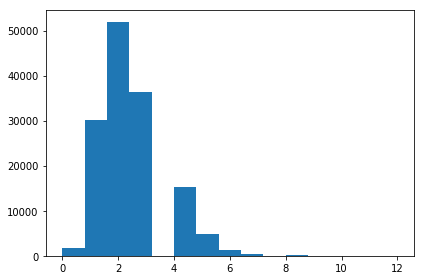

In [56]:

num_bins = 15

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist([len(x) for x in copies], num_bins)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [59]:
ans_copies = []
unans_copies = []
for i, cop in enumerate(copies):
    ll = 0
    if cop is not None and cop:
        cop_lens = [len(x) for x in cop]
        ll = max(cop_lens)
    if labels[i] == False:
        ans_copies.append(ll)
    else:
        unans_copies.append(ll)

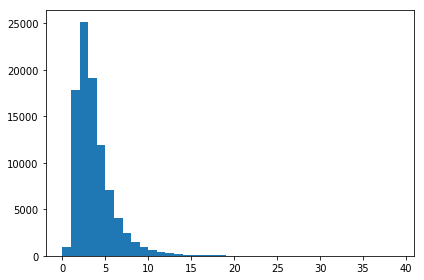

In [79]:

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(ans_copies, range(40))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

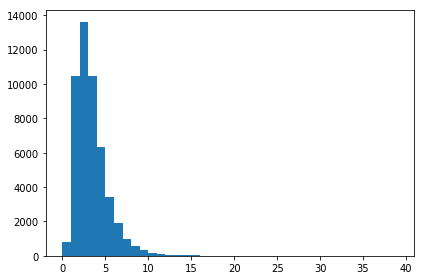

In [80]:

num_bins = 15

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(unans_copies, range(40))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [ ]:
# most common words in fake questions that aren't in context
# condition on parse tree?
# copies spans that have something swapped and antonym detector?
# not, date, change name, swap in a copy, antonym
# templating with BERT by doing the IsA trick


# The House of Lords introduced qualifications for which position?
#-> change of entity 

In [94]:
tokenized_contexts = []
for c in contexts:
    tokenized_contexts.append(tokenizer.tokenize(c))

In [96]:
def x_in_y_int(query, base):
    try:
        l = len(query)
    except TypeError:
        l = 1
        query = type(base)((query,))

    for i in range(len(base)):
        if base[i:i + l] == query:
            return i
    return -1

In [103]:
# min distance between 2 copied sections
dist_counter = {True: Counter(), False: Counter()}
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    copy_set = copies[qi]
    copy_starts = [x_in_y_int(copy, ct) for copy in copy_set]
    min_dist = 99999
    for i, i_start in enumerate(copy_starts):
        for j, j_start in enumerate(copy_starts):
            if i == j or i_start > j_start:
                continue
            
            dist = j_start - i_start - len(copy_set[i])
            if dist < min_dist:
                min_dist = dist
    label = labels[qi]
    dist_counter[label][min_dist] += 1

In [100]:
for i in list(range(5)) + [-1, 99999]:
    print(i, dist_counter[True][i])

0 2140
1 5474
2 3782
3 2434
4 1793
-1 471
99999 11654


In [101]:
for i in list(range(5)) + [-1, 99999]:
    print(i, dist_counter[False][i])

0 4950
1 11900
2 7966
3 4763
4 3711
-1 1108
99999 20302


In [102]:
#dist_counter = {True: Counter(), False: Counter()}
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    copy_set = copies[qi]
    copy_starts = [x_in_y_int(copy, ct) for copy in copy_set]
    min_dist = 99999
    for i, i_start in enumerate(copy_starts):
        for j, j_start in enumerate(copy_starts):
            if i == j or i_start > j_start:
                continue
            
            dist = j_start - i_start - len(copy_set[i])
            if dist < min_dist:
                min_dist = dist
    if min_dist == 0:
        print(q)
        print(c)
        print(q)
        print(copy_set)
        break
    label = labels[qi]
    #dist_counter[label][min_dist] += 1

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
What album made her a worldwide known artist?
[['album'], ['worldwide'], ['artist']]


In [158]:
# min distance between 2 copied sections
dist_counter = {True: Counter(), False: Counter()}
none_counter = 0
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    copy_set = copies[qi]
    copy_starts = [x_in_y_int(copy, ct) for copy in copy_set]
    min_dist = 99999
    for i, i_start in enumerate(copy_starts):
        if i >= len(copy_starts) - 1:
            break
        j_start = copy_starts[i+1]
        dist = j_start - i_start - len(copy_set[i])
        if dist == 1:
            tok = ct[j_start-1]
            if tok in nlp.vocab and nlp.vocab[tok].is_punct or nlp.vocab[tok].is_stop:
                continue
        if dist < min_dist:
            min_dist = dist
    if min_dist < 99999:
        label = labels[qi]
        dist_counter[label][min_dist] += 1
    else:
        none_counter += 1

In [164]:
sum(dist_counter[True].values()), sum(dist_counter[False].values())

(37064, 70521)

In [168]:
for i in list(range(5)) + [-1]:
    print(i, dist_counter[True][i] / sum(dist_counter[True].values()) * 100)

0 1.4002805957263114
1 2.4660047485430607
2 4.883444852147637
3 2.897690481329592
4 1.902115260090654
-1 0.1915605439240233


In [167]:
for i in list(range(5)) + [-1]:
    print(i, dist_counter[False][i] / sum(dist_counter[False].values()) * 100)

0 1.7002027764779284
1 2.1794926333999802
2 5.032543497681542
3 2.8232725003899546
4 2.0674692644744117
-1 0.21837466853844956


In [134]:
# min distance between 2 copied sections
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    copy_set = copies[qi]
    copy_starts = [x_in_y_int(copy, ct) for copy in copy_set]
    min_dist = 99999
    for i, i_start in enumerate(copy_starts):
        if i >= len(copy_starts) - 1:
            break
        j_start = copy_starts[i+1]
        dist = j_start - i_start - len(copy_set[i])
        if dist == 1:
            tok = ct[j_start-1]
            if tok in nlp.vocab and nlp.vocab[tok].is_punct or nlp.vocab[tok].is_stop:
                continue
        if dist < min_dist:
            min_dist = dist
    if min_dist == 1 and qi > 2723 and labels[qi] == True:
        print(qi)
        print(c)
        print(labels[qi], q)
        print(copy_set)
        break

2727
After wrapping up in England, production travelled to Morocco in June, with filming taking place in Oujda, Tangier and Erfoud, after preliminary work was completed by the production's second unit. An explosion filmed in Morocco holds a Guinness World Record for the "Largest film stunt explosion" in cinematic history, with the record credited to production designer Chris Corbould. Principal photography concluded on 5 July 2015. A wrap-up party for Spectre was held in commemoration before entering post-production. Filming took 128 days.
True An explosion filmed in what city holds the Guinness World Record for "Smallest film stunt explosion"?
[['explosion', 'filmed', 'in'], ['holds'], ['guinness', 'world', 'record', 'for'], ['film', 'stunt', 'explosion']]


In [161]:
middle_token = {True: Counter(), False: Counter()}
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    copy_set = copies[qi]
    copy_starts = [x_in_y_int(copy, ct) for copy in copy_set]
    min_dist = 99999
    min_j = -1
    for i, i_start in enumerate(copy_starts):
        if i >= len(copy_starts) - 1:
            break
        j_start = copy_starts[i+1]
        dist = j_start - i_start - len(copy_set[i])
        if dist == 1:
            tok = ct[j_start-1]
            if tok in nlp.vocab and nlp.vocab[tok].is_punct or nlp.vocab[tok].is_stop:
                continue
        if dist < min_dist:
            min_dist = dist
            min_j = j_start
    if min_dist == 1:
        label = labels[qi]
        middle_token[label][ct[min_j-1]] += 1

In [162]:
middle_token[True].most_common(25)

[('took', 7),
 ('##s', 7),
 ('began', 7),
 ('largest', 7),
 ('large', 6),
 ('north', 6),
 ('political', 6),
 ('second', 5),
 ('low', 5),
 ('significant', 5),
 ('typically', 4),
 ('hd', 4),
 ('lines', 4),
 ('human', 4),
 ('electric', 4),
 ('new', 4),
 ('8', 4),
 ('dark', 4),
 ('##ed', 3),
 ('eastern', 3),
 ('western', 3),
 ('northwest', 3),
 ('navigation', 3),
 ('20th', 3),
 ('aircraft', 3)]

In [163]:
middle_token[False].most_common(25)

[('##s', 22),
 ('took', 12),
 ('##ing', 10),
 ('began', 9),
 ('studio', 8),
 ('national', 8),
 ('gave', 7),
 ('known', 7),
 ('natural', 6),
 ('gained', 6),
 ('announced', 6),
 ('different', 6),
 ('##berg', 6),
 ('largest', 5),
 ('developed', 5),
 ('went', 5),
 ('single', 5),
 ('entered', 5),
 ('visited', 5),
 ('granted', 5),
 ('names', 4),
 ('television', 4),
 ('november', 4),
 ('##ed', 4),
 ('acquired', 4)]

In [148]:
sum(dist_counter[True].values()) + sum(dist_counter[False].values()) + none_counter 

142192

In [149]:
len(questions)

142192

In [171]:
# min distance between 2 copied sections
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    copy_set = copies[qi]
    copy_starts = [x_in_y_int(copy, ct) for copy in copy_set]
    min_dist = 99999
    min_j = -1
    for i, i_start in enumerate(copy_starts):
        if i >= len(copy_starts) - 1:
            break
        j_start = copy_starts[i+1]
        dist = j_start - i_start - len(copy_set[i])
        if dist == 1:
            tok = ct[j_start-1]
            if tok in nlp.vocab and nlp.vocab[tok].is_punct or nlp.vocab[tok].is_stop:
                continue
        if dist < min_dist:
            min_dist = dist
            min_j = j_start
    if min_dist == 1 and ct[min_j-1] == '##ed' and qi > 5453:
        print(qi)
        print(c)
        print(labels[qi], q)
        print(copy_set)
        break

8768
Most of the Low Countries had come under the rule of the House of Burgundy and subsequently the House of Habsburg. In 1549 Holy Roman Emperor Charles V issued the Pragmatic Sanction, which further unified the Seventeen Provinces under his rule. Charles was succeeded by his son, King Philip II of Spain. In 1568 the Netherlands, led by William I of Orange, revolted against Philip II because of high taxes, persecution of Protestants by the government, and Philip's efforts to modernize and centralize the devolved-medieval government structures of the provinces. This was the start of the Eighty Years' War.
True When did the House of Burgundy revolt against Philip II?
[['house', 'of', 'burgundy'], ['revolt'], ['against', 'philip', 'ii']]


In [238]:
tokenized_questions = []
for q in questions:
    tokenized_questions.append(tokenizer.tokenize(q))

In [246]:
of_counter = {True:0, False:0}
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    qt = tokenized_questions[qi]
    copy_set = copies[qi]
    for copy in copy_set:
        start = x_in_y_int(copy, qt)
        cstart = x_in_y_int(copy, ct)
        if (start != 0 and qt[start-1] == 'of' and cstart !=0 and ct[cstart-1] == 'of') or \
        ((start+len(copy)) < len(qt) and qt[start+len(copy)] == 'of' and cstart+len(copy) < len(ct) and ct[cstart+len(copy)] == 'of'):
            of_counter[labels[qi]] += 1

In [391]:
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    qt = tokenized_questions[qi]
    copy_set = copies[qi]
    for copy in copy_set:
        start = x_in_y_int(copy, qt)
        cstart = x_in_y_int(copy, ct)
        if (start != 0 and qt[start-1] == 'of' and cstart !=0 and ct[cstart-1] == 'of') or \
        ((start+len(copy)) < len(qt) and qt[start+len(copy)] == 'of' and cstart+len(copy) < len(ct) and ct[cstart+len(copy)] == 'of'):
            if qi > 342 and labels[qi] == False:
                print(qi, "||",labels[qi], "||", q)
                print(c)
                print(copy_set)
                assert False

358 || False || What is included at the end of Glory?
On January 7, 2012, Beyoncé gave birth to a daughter, Blue Ivy Carter, at Lenox Hill Hospital in New York under heavy security. Two days later, Jay Z released "Glory", a song dedicated to their child, on his website Lifeandtimes.com. The song detailed the couple's pregnancy struggles, including a miscarriage Beyoncé suffered before becoming pregnant with Blue Ivy. Blue Ivy's cries are included at the end of the song, and she was officially credited as "B.I.C." on it. At two days old, she became the youngest person ever to appear on a Billboard chart when "Glory" debuted on the Hot R&B/Hip-Hop Songs chart.
[['included', 'at', 'the', 'end'], ['glory']]


AssertionError: 

In [389]:
of_counter[True]/ np.sum(labels), of_counter[False]/ (len(labels) - np.sum(labels))

(0.07584491232328136, 0.06279312984506571)

In [412]:
for e in examples:
    ci, qi = e
    c = contexts[ci]
    ct = tokenized_contexts[ci]
    q = questions[qi]
    qt = tokenized_questions[qi]
    copy_set = copies[qi]
    for copy in copy_set:
        start = x_in_y_int(copy, qt)
        cstart = x_in_y_int(copy, ct)
        if labels[qi] == True and qi > 0:
            print(qi, "||",labels[qi], "||", q)
            print(c)
            print(copy_set)
            assert False

2075 || True || What category of game is Legend of Zelda: Australia Twilight?
The Legend of Zelda: Twilight Princess (Japanese: ゼルダの伝説 トワイライトプリンセス, Hepburn: Zeruda no Densetsu: Towairaito Purinsesu?) is an action-adventure game developed and published by Nintendo for the GameCube and Wii home video game consoles. It is the thirteenth installment in the The Legend of Zelda series. Originally planned for release on the GameCube in November 2005, Twilight Princess was delayed by Nintendo to allow its developers to refine the game, add more content, and port it to the Wii. The Wii version was released alongside the console in North America in November 2006, and in Japan, Europe, and Australia the following month. The GameCube version was released worldwide in December 2006.[b]
[['game'], ['legend', 'of', 'ze', '##lda'], ['australia'], ['twilight']]


AssertionError: 

The "of" trick doesn't really work becaue while there are many cases where the question replaces the X of Y with x' or y' where x != x', there are many cases where x' is a paraphrasing of x, which is the case in the answerable questions. It also has some to do with co-reference (the song vs Glory) or just parse errors (As of Aug..-> where as of are removed because they are stop words).

# Detecting change of meaning

In [173]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertForMaskedLM

# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cpu')
segments_tensors = segments_tensors.to('cpu')
model.to('cpu')

# Predict all tokens
with torch.no_grad():
    predictions = model(tokens_tensor, segments_tensors)

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/daniter/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/daniter/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/daniter/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/xx/8h5l1j614vv5wmbx9fbj69wm0000gn/T/tmpjml12ham
INFO:pytorch_pretrained_bert.modeling:Model c

In [211]:
def top_k_masked(text):
    tokenized_text = tokenizer.tokenize("[CLS] " + text)
    tokenized_text = [t if not t=='@' else '[MASK]' for t in tokenized_text]
    masked_index = tokenized_text.index('[MASK]')
    print(tokenized_text)

    # Convert token to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
    if '[SEP]' not in tokenized_text:
        segments_ids = [0]*len(indexed_tokens)
    else:
        idx = tokenized_text.index('[SEP]')
        segments_ids = [0]*idx + [1] * (len(indexed_tokens) - idx)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # If you have a GPU, put everything on cuda
    tokens_tensor = tokens_tensor.to('cpu')
    segments_tensors = segments_tensors.to('cpu')

    # Predict all tokens
    with torch.no_grad():
        predictions = model(tokens_tensor, segments_tensors)

    # confirm we were able to predict 'henson'
    predictions = predictions[0, masked_index]
    scores = Counter()
    for i, score in enumerate(predictions):
        scores[tokenizer.convert_ids_to_tokens([i])[0]] = score
    return scores

In [212]:
c = top_k_masked("largest @ smallest")
for a,b in c.most_common(20):
    print(a,b)

['[CLS]', 'largest', '[MASK]', 'smallest']
and tensor(8.1508)
or tensor(6.4708)
, tensor(6.2725)
& tensor(5.9001)
- tensor(5.7513)
of tensor(5.3609)
/ tensor(4.7303)
the tensor(4.4213)
: tensor(4.3504)
. tensor(4.1448)
) tensor(4.1330)
to tensor(4.0987)
( tensor(3.9033)
group tensor(3.6704)
is tensor(3.3524)
in tensor(3.2864)
; tensor(3.2606)
non tensor(3.2527)
with tensor(3.1733)
family tensor(3.0458)


# ideas
x log-odds of words  
x import wordnet and find antonyms  
x look at 'of' in edge words  
look at adversarial training (teach model opposites / alternative nouns/entities)  
copy model (given mask, predict if it's copied and if so, just do span match)  
make coverage + precision map  

- train new model w/ adversarial  
- train model with new mask feature  
- train model with copy feature and distribution  
- think about how we can determine if someting is a surprise vs a paraphrase?  

In [277]:
context_tokens = Counter()
for c in tokenized_contexts:
    for tok in c:
        context_tokens[tok] += 1
tokens = {True: Counter(), False: Counter()}
for i, qt in enumerate(tokenized_questions):
    label = labels[i]
    for tok in qt:
        tokens[label][tok] += 1
normalized_tokens = {True: Counter(), False: Counter()}
for k, v in tokens.items():
    for tok, count in v.items():
        normalized_tokens[k][tok] = count / context_tokens[tok] if tok in context_tokens else 1


In [286]:
diff_counter = Counter()
for k,v in normalized_tokens[False].items():
    diff_counter[k] = normalized_tokens[True][k] - v

In [287]:
diff_counter.most_common(25)

[('weren', 17.799999999999997),
 ('isn', 16.23076923076923),
 ('wasn', 11.916666666666666),
 ('aren', 10.0),
 ('hasn', 7.5),
 ('didn', 6.837209302325581),
 ('doesn', 6.066666666666666),
 ('smallest', 2.926829268292683),
 ('cares', 2.0),
 ('gora', 2.0),
 ('##lowe', 2.0),
 ('sd', 1.8636363636363635),
 ('wouldn', 1.8571428571428572),
 ('t', 1.7075718015665795),
 ('uncommon', 1.5588235294117647),
 ('shouldn', 1.5),
 ('sherlock', 1.3333333333333335),
 ('stalking', 1.3333333333333335),
 ('benedictine', 1.2941176470588234),
 ('never', 1.292929292929293),
 ('fake', 1.25),
 ('unofficially', 1.222222222222222),
 ('2018', 1.2),
 ('unpublished', 1.1666666666666665),
 ('steal', 1.1428571428571428)]

In [279]:
normalized_tokens[False].most_common(25)

[('?', 340.97769516728624),
 ('what', 57.39936440677966),
 ('how', 20.770020533880903),
 ('nyc', 19.8),
 ('kanye', 14.666666666666666),
 ('did', 14.586327782646801),
 ('announce', 10.555555555555555),
 ('_', 10.4),
 ('why', 9.426573426573427),
 ('happens', 8.434782608695652),
 ('does', 8.373493975903614),
 ('frederic', 7.4375),
 ('wwii', 7.166666666666667),
 ('advises', 7.0),
 ('##enity', 7.0),
 ('##sir', 7.0),
 ('feb', 7.0),
 ('percentage', 6.608),
 ('happened', 6.468085106382978),
 ('straightening', 6.0),
 ('type', 5.263392857142857),
 ('##with', 5.0),
 ('cops', 5.0),
 ('begin', 4.547169811320755),
 ('kind', 4.535714285714286)]

In [285]:
normalized_tokens[True].most_common(25)

[('?', 182.46468401486987),
 ('what', 33.20762711864407),
 ('weren', 19.4),
 ('isn', 18.23076923076923),
 ('wasn', 12.875),
 ('aren', 12.222222222222221),
 ('how', 9.634496919917865),
 ('hasn', 9.0),
 ('didn', 8.0),
 ('happens', 7.695652173913044),
 ('doesn', 7.466666666666667),
 ('did', 7.257668711656442),
 ('happened', 6.042553191489362),
 ('why', 5.5174825174825175),
 ('does', 5.010327022375215),
 ('wraps', 5.0),
 ('ripley', 5.0),
 ('cops', 5.0),
 ('mbc', 5.0),
 ('announce', 4.555555555555555),
 ('steals', 4.0),
 ('##with', 4.0),
 ('smallest', 3.5609756097560976),
 ('percentage', 3.44),
 ('wwii', 3.1666666666666665)]

In [288]:
from nltk.corpus import wordnet as wn

# Antonyms : check if antonyms occur often

In [385]:
sampled_examples_ans = []
sampled_examples_unans = []
for e in random.sample(examples, len(examples)):
    if labels[e[1]] == True and len(sampled_examples_unans) < 200:
        sampled_examples_unans.append(e)
    elif labels[e[1]] == False and len(sampled_examples_ans) < 200:
        sampled_examples_ans.append(e)
       

In [386]:
count_has_ant_ans = 0
count_has_ant_unans = 0
common_words_ans = Counter()
common_words_unans = Counter()
ant_in_context_ans = 0
ant_in_context_unans = 0
for ci, qi in sampled_examples_ans:
    q = questions[qi]
    c = contexts[ci]
    for tok in nlp(q):
        ss = wn.synsets(tok.lemma_)
        if ss:
            for l in ss[0].lemmas():
                if l.name() in ['on', 'many']:
                    continue
                if l.antonyms():
                    count_has_ant_ans += 1
                    common_words_ans[l.name()] +=1
                    for ant in l.antonyms()[0].synset().lemma_names():
                        if ant in c:
                            ant_in_context_ans += 1
for ci, qi in sampled_examples_unans:
    q = questions[qi]
    c = contexts[ci]
    for tok in nlp(q):
        ss = wn.synsets(tok.lemma_)
        if ss:
            for l in ss[0].lemmas():
                if l.name() in ['on', 'many']:
                    continue
                if l.antonyms():
                    count_has_ant_unans += 1
                    common_words_unans[l.name()] +=1
                    for ant in l.antonyms()[0].synset().lemma_names():
                        if ant in c:
                            ant_in_context_unans += 1
print(count_has_ant_ans, count_has_ant_unans)
print(ant_in_context_ans, ant_in_context_unans)
print(common_words_ans.most_common(25))
print("~"*20)
print(common_words_unans.most_common(25))


131 100
17 14
[('new', 5), ('most', 5), ('type', 4), ('some', 4), ('power', 4), ('powerfulness', 4), ('former', 3), ('inside', 3), ('all', 3), ('southern', 3), ('other', 3), ('necessitate', 2), ('believe', 2), ('defeat', 2), ('beginning', 2), ('complexity', 2), ('let', 2), ('belief', 2), ('likely', 2), ('high', 2), ('king', 2), ('male_monarch', 2), ('woman', 2), ('no', 1), ('relevant', 1)]
~~~~~~~~~~~~~~~~~~~~
[('type', 6), ('most', 5), ('new', 5), ('unremarkably', 4), ('black', 2), ('there', 2), ('necessitate', 2), ('agreement', 2), ('woman', 2), ('believe', 2), ('early', 2), ('color', 2), ('different', 2), ('able', 2), ('high', 2), ('never', 2), ('lose', 1), ('decrease', 1), ('arm', 1), ('security', 1), ('nuclear', 1), ('other', 1), ('king', 1), ('male_monarch', 1), ('asset', 1)]


In [420]:
for ci, qi in sampled_examples_unans:
    q = questions[qi]
    c = contexts[ci]
    for tok in nlp(q):
        ss = wn.synsets(tok.lemma_)
        if ss:
            for l in ss[0].lemmas():
                if l.name() in ['on', 'many']:
                    continue
                if l.antonyms():
                    for ant in l.antonyms()[0].synset().lemma_names():
                        if ant in c:
                            print(q)
                            print(c)
                            assert False



What decreased the pressure for people of African descent to be claimed by the black community?
After the Civil War, racial segregation forced African Americans to share more of a common lot in society than they might have given widely varying ancestry, educational and economic levels. The binary division altered the separate status of the traditionally free people of color in Louisiana, for instance, although they maintained a strong Louisiana Créole culture related to French culture and language, and practice of Catholicism. African Americans began to create common cause—regardless of their multiracial admixture or social and economic stratification. In 20th-century changes, during the rise of the Civil Rights and Black Power movements, the African-American community increased its own pressure for people of any portion of African descent to be claimed by the black community to add to its power.


AssertionError: 

In [298]:
for l in wn.synsets('largest')[0].lemmas():
    print(l.antonyms())

[Lemma('small.a.01.small')]
[Lemma('small.a.01.little')]


In [305]:
for s in wn.synsets('largest'):
    print(s.lemma_names())

['large', 'big']
['large']
['bombastic', 'declamatory', 'large', 'orotund', 'tumid', 'turgid']
['big', 'large', 'magnanimous']
['big', 'large', 'prominent']
['large']
['big', 'enceinte', 'expectant', 'gravid', 'great', 'large', 'heavy', 'with_child']


In [362]:
for q in random.sample(questions, 5):
    print(q)
    for tok in nlp(q):
        print(tok)
        ss = wn.synsets(tok.lemma_)
        if ss:
            #print(ss)
            for l in ss[0].lemmas():
                if l.antonyms():
                    print(l.antonyms()[0].synset().lemma_names())
        print("~"*20)

What do mens sexual orientations tend be focused on?
What
~~~~~~~~~~~~~~~~~~~~
do
~~~~~~~~~~~~~~~~~~~~
mens
~~~~~~~~~~~~~~~~~~~~
sexual
~~~~~~~~~~~~~~~~~~~~
orientations
~~~~~~~~~~~~~~~~~~~~
tend
~~~~~~~~~~~~~~~~~~~~
be
~~~~~~~~~~~~~~~~~~~~
focused
~~~~~~~~~~~~~~~~~~~~
on
['off']
~~~~~~~~~~~~~~~~~~~~
?
~~~~~~~~~~~~~~~~~~~~
What improved in 1936 because of the Royal Air Force?
What
~~~~~~~~~~~~~~~~~~~~
improved
['worsen', 'aggravate', 'exacerbate', 'exasperate']
~~~~~~~~~~~~~~~~~~~~
in
~~~~~~~~~~~~~~~~~~~~
1936
~~~~~~~~~~~~~~~~~~~~
because
~~~~~~~~~~~~~~~~~~~~
of
~~~~~~~~~~~~~~~~~~~~
the
~~~~~~~~~~~~~~~~~~~~
Royal
~~~~~~~~~~~~~~~~~~~~
Air
~~~~~~~~~~~~~~~~~~~~
Force
~~~~~~~~~~~~~~~~~~~~
?
~~~~~~~~~~~~~~~~~~~~
Who was the Collector for the port of Pennsylvania in 1715?
Who
~~~~~~~~~~~~~~~~~~~~
was
~~~~~~~~~~~~~~~~~~~~
the
~~~~~~~~~~~~~~~~~~~~
Collector
~~~~~~~~~~~~~~~~~~~~
for
~~~~~~~~~~~~~~~~~~~~
the
~~~~~~~~~~~~~~~~~~~~
port
~~~~~~~~~~~~~~~~~~~~
of
~~~~~~~~~~~~~~~~~~~~
Pennsylvania
~~~~

In [359]:
wn.synsets('fast')[3].lemmas()[0].antonyms()[0].synset().lemma_names()

['slow']

In [356]:
dir(wn.synsets('fast')[3].lemmas()[0].antonyms()[0].synset())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_all_hypernyms',
 '_definition',
 '_examples',
 '_frame_ids',
 '_hypernyms',
 '_instance_hypernyms',
 '_iter_hypernym_lists',
 '_lemma_names',
 '_lemma_pointers',
 '_lemmas',
 '_lexname',
 '_max_depth',
 '_min_depth',
 '_name',
 '_needs_root',
 '_offset',
 '_pointers',
 '_pos',
 '_related',
 '_shortest_hypernym_paths',
 '_wordnet_corpus_reader',
 'also_sees',
 'attributes',
 'causes',
 'closure',
 'common_hypernyms',
 'definition',
 'entailments',
 'examples',
 'frame_ids',
 'hypernym_distances',
 'hypernym_paths',
 'hypernyms',
 'hyponyms',
 'in_region_domains',
 'in_topic_domains',
 'in_us

# BIDAF

In [306]:
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/bidaf-model-2017.09.15-charpad.tar.gz")
predictor.predict(
  passage="The Matrix is a 1999 science fiction action film written and directed by The Wachowskis, starring Keanu Reeves, Laurence Fishburne, Carrie-Anne Moss, Hugo Weaving, and Joe Pantoliano.",
  question="Who stars in The Matrix?"
)

INFO:allennlp.common.file_utils:https://s3-us-west-2.amazonaws.com/allennlp/models/bidaf-model-2017.09.15-charpad.tar.gz not found in cache, downloading to /var/folders/xx/8h5l1j614vv5wmbx9fbj69wm0000gn/T/tmppcopo7z3
100%|██████████| 46175392/46175392 [00:17<00:00, 2675461.71B/s]
INFO:allennlp.common.file_utils:copying /var/folders/xx/8h5l1j614vv5wmbx9fbj69wm0000gn/T/tmppcopo7z3 to cache at /Users/daniter/.allennlp/cache/6b2f329c57e41fb613be7e3538001f1f74dabceaf0a8562def91090fa652bef3.0b385ab2f40b25a4b2289de2798c8c7ffd779392f1b7a21a1f1ed81e49859300
INFO:allennlp.common.file_utils:creating metadata file for /Users/daniter/.allennlp/cache/6b2f329c57e41fb613be7e3538001f1f74dabceaf0a8562def91090fa652bef3.0b385ab2f40b25a4b2289de2798c8c7ffd779392f1b7a21a1f1ed81e49859300
INFO:allennlp.common.file_utils:removing temp file /var/folders/xx/8h5l1j614vv5wmbx9fbj69wm0000gn/T/tmppcopo7z3
INFO:allennlp.models.archival:loading archive file https://s3-us-west-2.amazonaws.com/allennlp/models/bidaf-model

INFO:allennlp.common.params:model.text_field_embedder.tokens.projection_dim = None
INFO:allennlp.common.params:model.text_field_embedder.tokens.trainable = False
INFO:allennlp.common.params:model.text_field_embedder.tokens.padding_index = None
INFO:allennlp.common.params:model.text_field_embedder.tokens.max_norm = None
INFO:allennlp.common.params:model.text_field_embedder.tokens.norm_type = 2.0
INFO:allennlp.common.params:model.text_field_embedder.tokens.scale_grad_by_freq = False
INFO:allennlp.common.params:model.text_field_embedder.tokens.sparse = False
INFO:allennlp.common.params:model.num_highway_layers = 2
INFO:allennlp.common.from_params:instantiating class <class 'allennlp.modules.seq2seq_encoders.seq2seq_encoder.Seq2SeqEncoder'> from params {'bidirectional': True, 'dropout': 0.2, 'hidden_size': 100, 'input_size': 200, 'num_layers': 1, 'type': 'lstm'} and extras {'vocab': Vocabulary with namespaces:  tokens, Size: 97914 || Non Padded Namespaces: {'*labels', '*tags'}}
INFO:allenn

INFO:allennlp.nn.initializers:   _span_end_encoder._module.weight_hh_l0
INFO:allennlp.nn.initializers:   _span_end_encoder._module.weight_hh_l0_reverse
INFO:allennlp.nn.initializers:   _span_end_encoder._module.weight_ih_l0
INFO:allennlp.nn.initializers:   _span_end_encoder._module.weight_ih_l0_reverse
INFO:allennlp.nn.initializers:   _span_end_predictor._module.bias
INFO:allennlp.nn.initializers:   _span_end_predictor._module.weight
INFO:allennlp.nn.initializers:   _span_start_predictor._module.bias
INFO:allennlp.nn.initializers:   _span_start_predictor._module.weight
INFO:allennlp.nn.initializers:   _text_field_embedder.token_embedder_token_characters._embedding._module.weight
INFO:allennlp.nn.initializers:   _text_field_embedder.token_embedder_token_characters._encoder._module.conv_layer_0.bias
INFO:allennlp.nn.initializers:   _text_field_embedder.token_embedder_token_characters._encoder._module.conv_layer_0.weight
INFO:allennlp.nn.initializers:   _text_field_embedder.token_embedder

{'passage_question_attention': [[0.2332495003938675,
   0.13020572066307068,
   0.05738387629389763,
   0.4639679491519928,
   0.07980171591043472,
   0.03539126738905907],
  [0.022366061806678772,
   0.041481345891952515,
   0.004440483637154102,
   0.010942183434963226,
   0.9152997136116028,
   0.0054702130146324635],
  [0.4210350513458252,
   0.14624372124671936,
   0.1435588300228119,
   0.04770353436470032,
   0.06846389174461365,
   0.17299500107765198],
  [0.41911062598228455,
   0.22678565979003906,
   0.1360650211572647,
   0.09948630630970001,
   0.03831887245178223,
   0.08023352175951004],
  [0.3584285080432892,
   0.24447961151599884,
   0.14123569428920746,
   0.05731037259101868,
   0.04445306584239006,
   0.15409281849861145],
  [0.38292989134788513,
   0.2086879014968872,
   0.18444578349590302,
   0.04652712121605873,
   0.05981538072228432,
   0.11759379506111145],
  [0.2734203040599823,
   0.43692219257354736,
   0.12022325396537781,
   0.05061645060777664,
   0.04

In [317]:
result.keys()

dict_keys(['passage_question_attention', 'span_start_logits', 'span_start_probs', 'span_end_logits', 'span_end_probs', 'best_span', 'best_span_str', 'question_tokens', 'passage_tokens'])

In [307]:
result = predictor.predict(
  passage="The Matrix is a 1999 science fiction action film written and directed by The Wachowskis, starring Keanu Reeves, Laurence Fishburne, Carrie-Anne Moss, Hugo Weaving, and Joe Pantoliano.",
  question="Who stars in The Matrix?"
)

In [316]:
result["passage_question_attention"][0]

[0.2332495003938675,
 0.13020572066307068,
 0.05738387629389763,
 0.4639679491519928,
 0.07980171591043472,
 0.03539126738905907]

In [320]:
len(result['passage_tokens'])

35

In [315]:
passage="The Matrix is a 1999 science fiction action film written and directed by The Wachowskis, starring Keanu Reeves, Laurence Fishburne, Carrie-Anne Moss, Hugo Weaving, and Joe Pantoliano."
len(passage.split(" "))

27

In [324]:
for c,q in examples:
    context = contexts[c]
    question = questions[q]
    if ' east ' in question and ' river ' in question and "Appalachian Mountains" in question:
        print(context)
        print (question)

The five Great Lakes are located in the north-central portion of the country, four of them forming part of the border with Canada, only Lake Michigan situated entirely within United States. The southeast United States contain subtropical forests and, near the gulf coast, mangrove wetlands, especially in Florida. West of the Appalachians lies the Mississippi River basin and two large eastern tributaries, the Ohio River and the Tennessee River. The Ohio and Tennessee Valleys and the Midwest consist largely of rolling hills and productive farmland, stretching south to the Gulf Coast.
Which major river is located east of the Appalachian Mountains


# TODO:
- get attention for all squad  
- find all antonyms and do adversarial training
- use bertscore for paraphrasing

x log-odds of words  
x import wordnet and find antonyms  
x look at 'of' in edge words  
look at adversarial training (teach model opposites / alternative nouns/entities)   
copy model (given mask, predict if it's copied and if so, just do span match)  
make coverage + precision map  
 
train new model w/ adversarial  
train model with new mask feature  
train model with copy feature and distribution  
think about how we can determine if someting is a surprise vs a paraphrase?  

In [364]:
for c in contexts:
    if 'House of Commons' in c:
        print(c)

In the mid 17th century, after the English Civil War (1642–1651), Parliament strengthened its position relative to the monarch then gained more power through the Glorious Revolution of 1688 and passage of the Bill of Rights in 1689. The monarch could no longer establish any law or impose any tax without its permission and thus the House of Commons became a part of the government. It is at this point that a modern style of prime minister begins to emerge.
From 1721 this was the Whig politician Robert Walpole, who held office for twenty-one years. Walpole chaired cabinet meetings, appointed all the other ministers, dispensed the royal patronage and packed the House of Commons with his supporters. Under Walpole, the doctrine of cabinet solidarity developed. Walpole required that no minister other than himself have private dealings with the king, and also that when the cabinet had agreed on a policy, all ministers must defend it in public, or resign. As a later prime minister, Lord Melbour

In surveys made in Europe and the United States, green is the color most commonly associated with nature, life, health, youth, spring, hope and envy. In Europe and the U.S. green is sometimes associated with death (green has several seemingly contrary associations), sickness, or the devil, but in China its associations are very positive, as the symbol of fertility and happiness. In the Middle Ages and Renaissance, when the color of clothing showed the owner's social status, green was worn by merchants, bankers and the gentry, while red was the color of the nobility. The Mona Lisa by Leonardo da Vinci wears green, showing she is not from a noble family; the benches in the British House of Commons are green, while those in the House of Lords are red. Green is also the traditional color of safety and permission; a green light means go ahead, a green card permits permanent residence in the United States. It is the most important color in Islam. It was the color of the banner of Muhammad, a